In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv') # 2013 01 - 2017 12
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv')  # 2018 01-03


def dmy_sep_dayofweek(df):
    df['date'] = pd.to_datetime(df.date, format="%Y-%m-%d")
    df['day'] = df.date.dt.day
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['day_of_week'] = df.date.dt.dayofweek  # Mon:0, Sun: 6
    return df
    
train = dmy_sep_dayofweek(train)
test = dmy_sep_dayofweek(test)


# relative sales ('smoother' to predict)
# Yearly growth pattern -> predict the next pt in curve
sales_avg = train.sales.mean()
rel_sales_byYear = pd.pivot_table(train, index='year', values='sales', aggfunc=np.mean)
rel_sales_byYear /= sales_avg
rel_sales_byYear


,sales
year,
2013,0.832793
2014,0.958032
2015,1.000127
2016,1.083181
2017,1.125640


In [3]:
rel_sales_year = rel_sales_byYear.values.squeeze()
rel_sales_year

array([0.83279275, 0.95803178, 1.00012685, 1.08318071, 1.12564001])

In [4]:
degree=2
factor=4

years = np.arange(2013, 2018)
weights = np.exp((years - 2018)/factor)

polyfit_on_year = np.poly1d(np.polyfit(years, rel_sales_year, degree, w=weights))
print(f"2018 Relative Sales by Weighted Fit = {polyfit_on_year(2018)}")

2018 Relative Sales by Weighted Fit = 1.1583199177148344


Text(0.5, 0, 'Year')

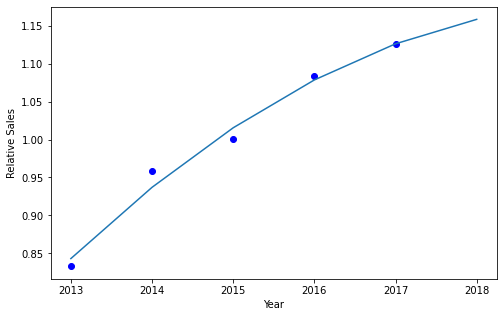

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(2013,2018), rel_sales_year, 'bo')
plt.plot(range(2013,2019), polyfit_on_year(range(2013,2019)))
plt.ylabel("Relative Sales")
plt.xlabel("Year")

In [6]:
#test set are all in 2018
rel_sales2018 = round(polyfit_on_year(2018), 5)

# instead of prediction, multiply past sales by factors
# 1. base sales day of week-item
# 2. day of week>year>month>item factors
base_sales_ref = pd.pivot_table(train, index='day_of_week', columns='item', values='sales',aggfunc=np.mean)
monthly_relSales = pd.pivot_table(train, index='month', values='sales',aggfunc=np.mean)
monthly_relSales.sales /= sales_avg
store_relSales = pd.pivot_table(train, index='store', values='sales',aggfunc=np.mean)
store_relSales.sales /= sales_avg

submission = pd.DataFrame(test['id'])
submission['sales'] = np.nan

for _, row in test.iterrows():
    dayofweek, month, year, item, store = row.day_of_week, row.month, row.year, row['item'], row.store
    base_sales = base_sales_ref.loc[dayofweek, item]
    monthFactor = monthly_relSales.loc[month]
    storeFactor = store_relSales.loc[store]
    pred_sales = base_sales * monthFactor * storeFactor * rel_sales2018
    submission.at[row['id'], 'sales'] = pred_sales
    

submission['sales'] = np.round(submission['sales']).astype(int)
submission.to_csv('submission.csv', index=False)